# START HERE for EERIE IFS-AMIP production runs

## Introduction

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import intake

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import seaborn as sns

from datetime import datetime

from dask.diagnostics import ProgressBar

# import iris
# import iris.analysis as ia

def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")

# def get_area(da,mask=False):
#     print('Computing grid-box area')
#     import iris.analysis as ia
#     if 'time' in da.dims:
#         da = da.isel(time=0).drop('time')
#     d = da.to_iris()
#     d.coord('longitude').guess_bounds()
#     d.coord('latitude').guess_bounds()

#     area_weights = ia.cartography.area_weights(d)
#     area = xr.ones_like(da) * area_weights
#     if mask:
#         area = area.where(~np.isnan(da))
#     area = area.rename('area').load()
#     area.attrs['long_name'] = 'grid_box_area'
#     area.attrs['units'] = 'm^2'
#     return area

def print_var(ds,filt=None):
    '''
    Print variables (varname,name) in Dataset. 
    If <filt> is provided, print only those where <filt> is present in the <name> attribute (ds[shortname].attrs['name'])

    Usage: print_var(ds,'wind')
    Output: printout of variables in ds whose name (long name in attributes, not short name to access) contains 'wind', e.g.
        10si  :   10 metre wind speed
        10u  :   10 metre U wind component
        10v  :   10 metre V wind component
    '''
    if filt:
        [print('%10s  :   %s' % (d,ds[d].attrs['name'])) for d in ds if filt.lower() in ds[d].attrs['name'].lower()]
    else:
        [print('%10s  :   %s' % (d,ds[d].attrs['name'])) for d in ds]

def scatter_map(da,lon='longitude',lat='latitude',ax=None,cbar_kwargs={},**kwargs):
    '''
    Plot data from non lat-lon grid where each point has a latitude & longitude value
    '''
    
    if not len(da.shape) == 1:
        raise ValueError('Need to provide one-dimensional DataArray')
    
    if not 's' in kwargs.keys():
        kwargs['s'] = np.sqrt(abs(da))
    if not 'pad' in cbar_kwargs.keys():
        cbar_kwargs['pad'] = 0.025
    if not 'shrink' in cbar_kwargs.keys():
        cbar_kwargs['shrink'] = 0.5
        
    if ax == None:
#         fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(20,10),constrained_layout=True)
        fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(10,5),constrained_layout=True)
        p = ax.scatter(da[lon],da[lat],c=da,**kwargs)
        cbar = fig.colorbar(p,ax=ax,**cbar_kwargs)
        return ax
    else:
        p = ax.scatter(da[lon],da[lat],c=da,**kwargs)
        return p

def closest_point_index(coords,point):
    '''
    Get 'value' index corresponding to the closest gridpoint to a [lon,lat] point
    Assumes longitude coordinate in "coords" is [0,360] degrees East
    but supports lon in [-180,180] degrees East
    '''
    lon,lat = point
    if lon < 0:
        lon = 360+lon
    return ((((coords['lon'] - lon)**2 + (coords['lat'] - lat)**2))**0.5).sort_values().index[0]


def closest_point(ds,point,lonname='lon',latname='lat',coords=None):
    '''
    Extract closest gridpoint(s) to a [lon,lat] point
    point may be
        - [lon,lat] : one point
        - [ [lon1,lat1], ... , [lonn,latn] ] : a list of several points
    providing coords as a dataframe is optional (possibly speeding up by pre-loading the grid information)
    Assumes longitude coordinate in "coords" is [0,360] degrees East
    but supports lon in [-180,180] degrees East via closest_point_index
    '''
    if coords is None:
        # coords = ds[[lonname,latname]].to_dataframe()
        coords = pd.DataFrame.from_dict(
            {
                'lat':ds[latname].to_series(),
                'lon':ds[lonname].to_series()
            }
        )
    
    if len(np.array(point).shape) == 2: # several points
        idx = [closest_point_index(coords,pointi) for pointi in point]
    else: # only one point
        idx = closest_point_index(coords,point)
    return ds.sel(value=idx)

def get_box_native(ds,x0,x1,y0,y1,lon='lon',lat='lat',dim='value',to180=False):
    '''
    Extract a box on a native grid
    '''
    print('get box: [x0,x1,y0,y1]: [%s,%s,%s,%s]' % (x0,x1,y0,y1))
    #coords = ds[[lon,lat]]
    coords = {
        lon:ds[lon].load(),
        lat:ds[lat].load()
    }
    #print(coords)
    if to180:
        coords[lon] = np.mod(coords[lon] + 180, 360) - 180
        #print(coords['lon'].min(), coords['lon'].max())
    return ds.sel(
        {
            dim : ( 
                (coords[lat] > y0) 
                & (coords[lat] < y1) 
                & (coords[lon] > x0) 
                & (coords[lon] < x1) 
            ) 
        }
    )

In [2]:
# grid-box area (in m^2) of 0.25 x 0.25 degree regular grid on which most output is delivered
area = xr.open_dataarray('/work/bk1377/b382473/data/area_025.nc').load().rename(
    {
        'longitude':'lon',
        'latitude':'lat'
    }
)

## Open and inspect the catalogue

The data is sorted by resolution at the highest level - so sub-catalogues for the runs at tco1279 (~9 km) and tco399 (~28 km)

In [3]:
cat_1279 = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz']['disk']['model-output']['ifs-amip-tco1279']
cat_399 = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz']['disk']['model-output']['ifs-amip-tco399']

In [4]:
list(cat_1279)

['hist.v20240901.atmos.gr025',
 'hist.v20240901.wave.gr025',
 'hist.v20240901.atmos.native',
 'hist-c-0-a-lr20.v20240901.atmos.gr025',
 'hist-c-0-a-lr20.v20240901.wave.gr025',
 'hist-c-0-a-lr20.v20240901.atmos.native']

In [5]:
list(cat_399)

['hist-c-0-a-lr20.v20240901.atmos.gr025',
 'hist-c-0-a-lr20.v20240901.wave.gr025',
 'hist-c-0-a-lr20.v20240901.atmos.native',
 'hist-c-0-a-lr30.v20231006.atmos.gr025',
 'hist-c-0-a-lr30.v20231106.atmos.gr025',
 'hist-c-0-a-lr30.v20231106.atmos.native',
 'hist-c-0-a-lr30.v20240304.atmos.gr025',
 'hist-c-0-a-lr30.v20240304.atmos.native',
 'hist-c-lr20-a-0.v20240901.atmos.gr025',
 'hist-c-lr20-a-0.v20240901.wave.gr025',
 'hist-c-lr20-a-0.v20240901.atmos.native',
 'hist-c-lr30-a-0.v20231106.atmos.gr025',
 'hist-c-lr30-a-0.v20231106.atmos.native',
 'hist-c-lr30-a-lr30.v20231106.atmos.gr025',
 'hist-c-lr30-a-lr30.v20231106.atmos.native',
 'hist.v20231006.atmos.gr025',
 'hist.v20231106.atmos.gr025',
 'hist.v20231106.atmos.native',
 'hist.v20240304.atmos.gr025',
 'hist.v20240304.atmos.native',
 'hist.v20240901.atmos.gr025',
 'hist.v20240901.wave.gr025',
 'hist.v20240901.atmos.native']

### These also contain *preliminary* runs (used at previous hackathons). Consult the [documentation](https://github.com/eerie-project/EERIE_hackathon_2023/tree/main/IFS_AMIP) for specifics.
### The **production runs** are those with version **v20240901**

In [6]:
[l for l in list(cat_1279) if 'v20240901' in l]

['hist.v20240901.atmos.gr025',
 'hist.v20240901.wave.gr025',
 'hist.v20240901.atmos.native',
 'hist-c-0-a-lr20.v20240901.atmos.gr025',
 'hist-c-0-a-lr20.v20240901.wave.gr025',
 'hist-c-0-a-lr20.v20240901.atmos.native']

In [7]:
[l for l in list(cat_399) if 'v20240901' in l]

['hist-c-0-a-lr20.v20240901.atmos.gr025',
 'hist-c-0-a-lr20.v20240901.wave.gr025',
 'hist-c-0-a-lr20.v20240901.atmos.native',
 'hist-c-lr20-a-0.v20240901.atmos.gr025',
 'hist-c-lr20-a-0.v20240901.wave.gr025',
 'hist-c-lr20-a-0.v20240901.atmos.native',
 'hist.v20240901.atmos.gr025',
 'hist.v20240901.wave.gr025',
 'hist.v20240901.atmos.native']

In [8]:
list(cat_1279['hist.v20240901.atmos.gr025'])

['2D_monthly', '2D_24h', '3D_monthly', '3D_24h', '3D_6h']

In [9]:
ds_1279_2d_monthly = cat_1279['hist.v20240901.atmos.gr025']['2D_monthly'].to_dask()

In [10]:
ds_1279_2d_monthly

<xarray.Dataset>
Dimensions:       (time: 528, value: 1038240, level: 4)
Coordinates:
    lat           (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * level         (level) int64 1 2 3 4
    lon           (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time          (time) datetime64[ns] 1980-01-15T12:00:00 ... 2023-12-15T12...
Dimensions without coordinates: value
Data variables: (12/48)
    10fg          (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    avg_10u       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    avg_10v       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    avg_2d        (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    avg_2sh       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    avg_blh       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ...            ...
    mtnswrf       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnswrfcs     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtsfr         (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mvsw          (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    mx2t          (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tprate        (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

### Datasets on 0.25 degree grids (those from 'gr025' paths) can be reshaped to lat-lon coordinates:

In [11]:
ds_1279_2d_monthly = ifs_to_latlon(ds_1279_2d_monthly)

In [12]:
ds_1279_2d_monthly

<xarray.Dataset>
Dimensions:       (lat: 721, lon: 1440, level: 4, time: 528)
Coordinates:
  * lat           (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon           (lon) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * level         (level) int64 1 2 3 4
  * time          (time) datetime64[ns] 1980-01-15T12:00:00 ... 2023-12-15T12...
Data variables: (12/48)
    10fg          (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    avg_10u       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    avg_10v       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    avg_2d        (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    avg_2sh       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    avg_blh       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...            ...
    mtnswrf       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnswrfcs     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtsfr         (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mvsw          (time, level, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    mx2t          (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tprate        (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

# Simple plotting

### Simple plot on 0.25 degree output

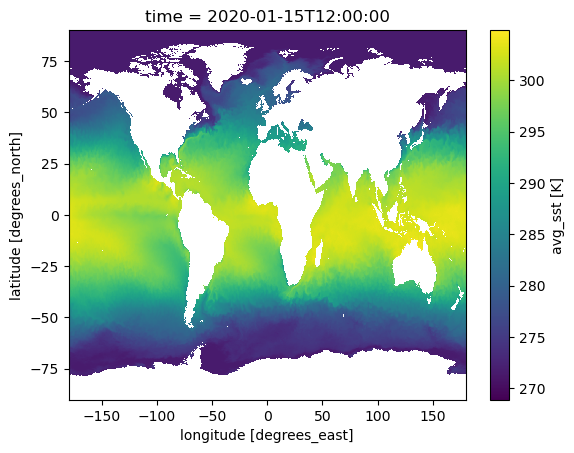

In [13]:
ds_1279_2d_monthly['avg_sst'].sel(time='2020-01-15 12:00').plot()

Text(0.5, 1.0, 'Monthly mean SST for January 2020')

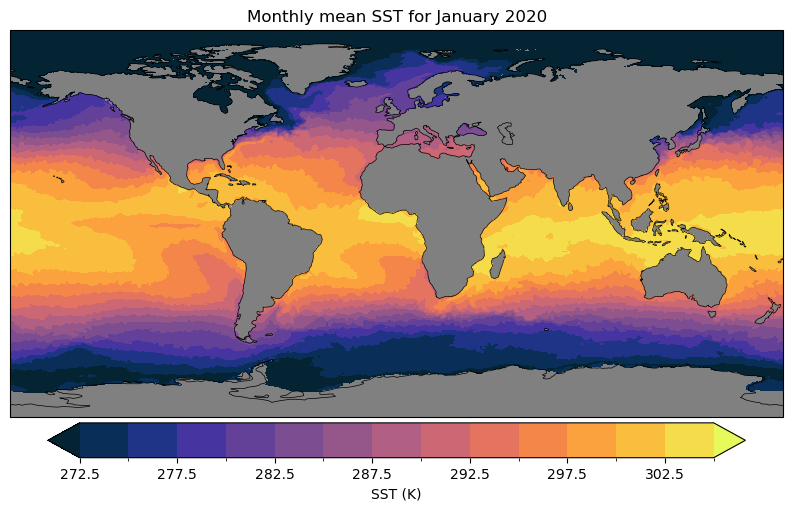

In [14]:
ff = ds_1279_2d_monthly['avg_sst'].sel(time='2020-01-15 12:00').plot.contourf(
    levels=np.arange(270+2.5,305+2.5,2.5),
    extend='both',
    cmap=cmo.thermal,
    subplot_kws=dict(
        projection=ccrs.PlateCarree()
    ),
    cbar_kwargs=dict(
        orientation='horizontal',
        shrink=0.9,
        pad=0.0125,
        label='SST (K)',
        extend='both'
    ),
    transform=ccrs.PlateCarree(),
    figsize=(10,6)
)

ff.axes.set_facecolor('grey')
ff.axes.coastlines(lw=0.5)
ff.axes.set_title('Monthly mean SST for January 2020')

### Simple plot on native grid

Native grid data is available (only for 2023) in the 'native' sub-catalogues

In [ ]:
ds_1279_2d_6h_native = cat_1279['hist.v20240901.atmos.native']['2D_6h'].to_dask()

Native grid data CANNOT be reshaped to a lat-lon grid with ifs_to_latlon! Attempting will crash your notebook.

In [16]:
ds_1279_2d_6h_native

<xarray.Dataset>
Dimensions:  (time: 1460, value: 6599680, level: 4)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4
    lon      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-12-31T18:00:00
Dimensions without coordinates: value
Data variables: (12/24)
    10si     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    2sh      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    ...       ...
    tcc      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    tciw     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    tclw     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    tcw      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    tcwv     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vsw      (time, level, value) float64 dask.array<chunksize=(1, 1, 6599680), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

But you can get a point or are with the functions closest_point and get_box_native

In [31]:
point_native = closest_point(
    ds_1279_2d_6h_native,
    [10,45]
)

box_native = get_box_native(
    ds_1279_2d_6h_native,
    -5,15,45,60,
    to180=True
)

get box: [x0,x1,y0,y1]: [-5,15,45,60]


In [89]:
point_native_2t = point_native['2t']
with ProgressBar():
    point_native_2t.load()

[########################################] | 100% Completed | 84.06 s


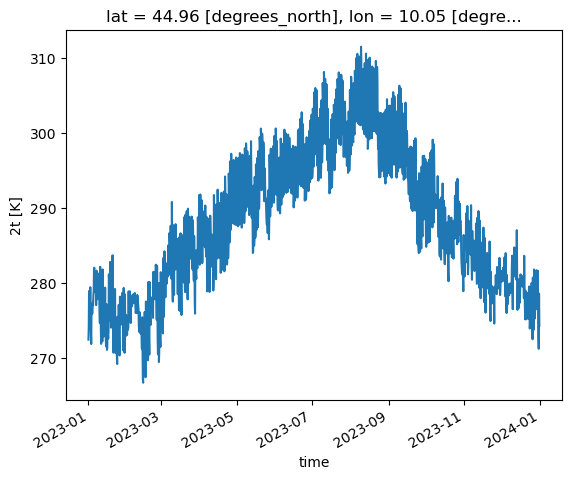

In [90]:
point_native_2t.plot()

In [39]:
box_native

<xarray.Dataset>
Dimensions:  (time: 1460, value: 25538, level: 4)
Coordinates:
    lat      (value) float64 60.0 60.0 60.0 60.0 ... 45.03 45.03 45.03 45.03
  * level    (level) int64 1 2 3 4
    lon      (value) float64 0.0 0.2088 0.4176 0.6265 ... 359.6 359.7 359.9
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-12-31T18:00:00
Dimensions without coordinates: value
Data variables: (12/24)
    10si     (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    2sh      (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    ...       ...
    tcc      (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    tciw     (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    tclw     (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    tcw      (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    tcwv     (time, value) float64 dask.array<chunksize=(1, 25538), meta=np.ndarray>
    vsw      (time, level, value) float64 dask.array<chunksize=(1, 1, 25538), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [32]:
box_native_select = box_native[['2t','i10fg']].sel(time='2023-03-04 12:00')

In [33]:
box_native_select

<xarray.Dataset>
Dimensions:  (value: 25538)
Coordinates:
    lat      (value) float64 60.0 60.0 60.0 60.0 ... 45.03 45.03 45.03 45.03
    lon      (value) float64 0.0 0.2088 0.4176 0.6265 ... 359.6 359.7 359.9
    time     datetime64[ns] 2023-03-04T12:00:00
Dimensions without coordinates: value
Data variables:
    2t       (value) float64 dask.array<chunksize=(25538,), meta=np.ndarray>
    i10fg    (value) float64 dask.array<chunksize=(25538,), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

Plot the section with the function scatter_map. It will plot a scatter plot, with a dot at each native model grid cell

Text(0.5, 1.0, '2-metre temperature (K) at 2023-03-04 12:00')

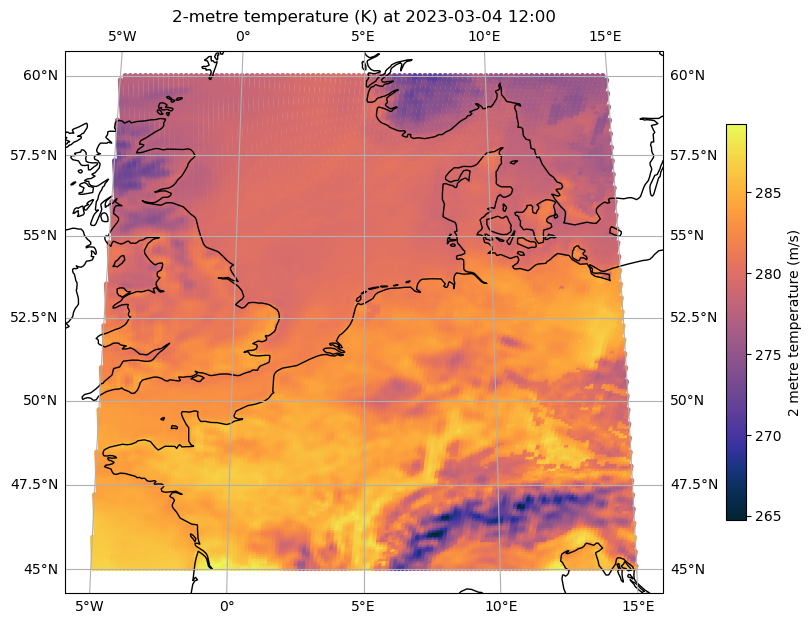

In [46]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(8,8),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=5)))
p = scatter_map(
    box_native_select['2t'],
    lon='lon',lat='lat',
    s=8,
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmo.thermal
)
ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = fig.colorbar(p,ax=ax,label='2 metre temperature (m/s)',shrink=0.5,pad=0.0125)
ax.set_title('2-metre temperature (K) at 2023-03-04 12:00')

Text(0.5, 1.0, 'wind gust (m/s) at 2023-03-04 12:00')

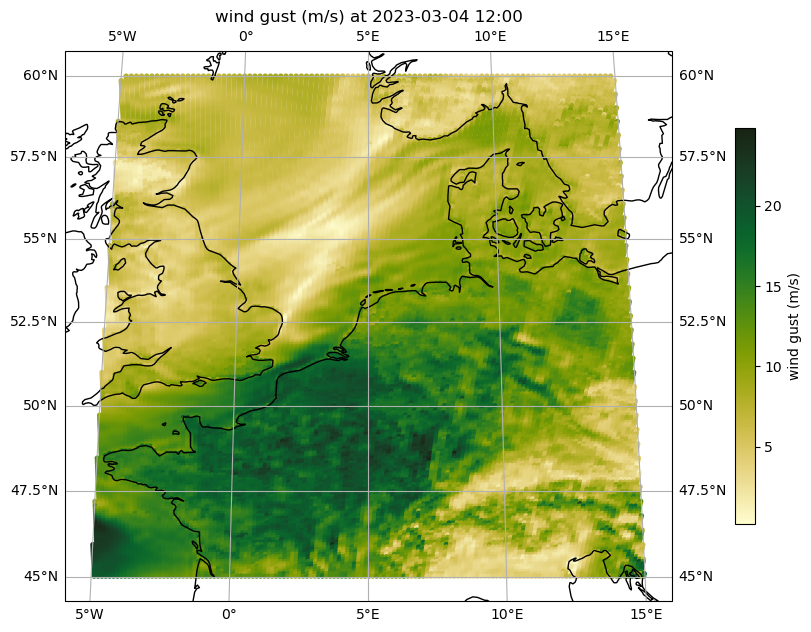

In [44]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(8,8),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=5)))
p = scatter_map(
    box_native_select['i10fg'],
    lon='lon',lat='lat',
    s=8,
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmo.speed
)
ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = fig.colorbar(p,ax=ax,label='wind gust (m/s)',shrink=0.5,pad=0.0125)
ax.set_title('wind gust (m/s) at 2023-03-04 12:00')

## Data processing examples

### Global mean area-weighted monthly sea surface and surface air temperature

(3652.0, 19722.0)

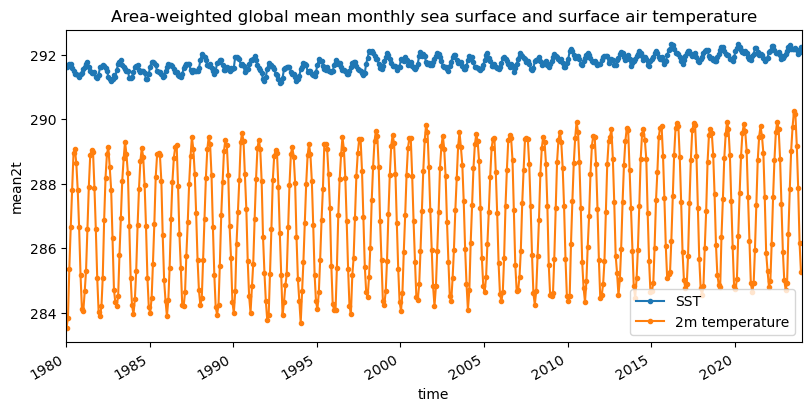

In [32]:
fig, ax = plt.subplots(figsize=(8,4),constrained_layout=True)

ds_1279_2d_monthly['avg_sst'].weighted(area).mean(['lat','lon']).plot.line(
 '.-',label='SST',ax=ax)
ds_1279_2d_monthly['mean2t'].weighted(area).mean(['lat','lon']).plot.line(
 '.-',label='2m temperature',ax=ax)

ax.legend()
ax.set_title("Area-weighted global mean monthly sea surface and surface air temperature")

ax.set_xlim(
    datetime(1980,1,1),
    datetime(2023,12,31)
)

Text(0.5, 1.0, 'Zonal-mean total precipitation')

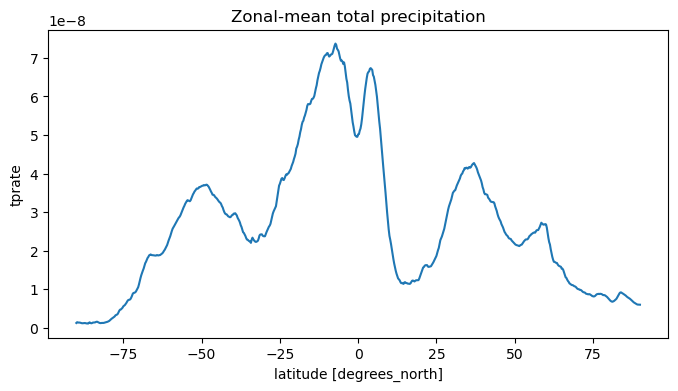

In [33]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
ds_1279_2d_monthly['tprate'].isel(time=0).mean('lon').plot(ax=ax)
plt.title('Zonal-mean total precipitation')

Text(0.5, 1.0, 'Hovmoeller plot of total precipitation')

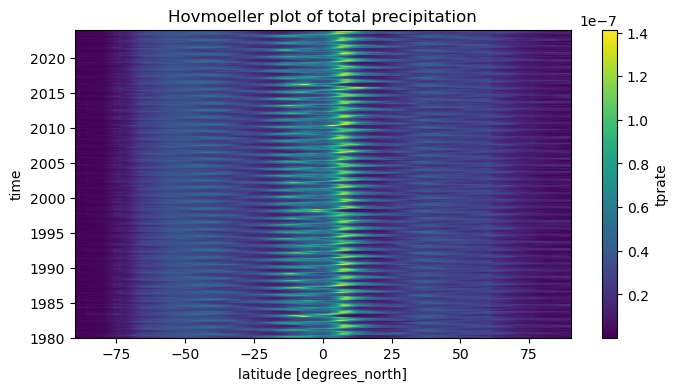

In [34]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
ds_1279_2d_monthly['tprate'].mean('lon').plot(ax=ax)
plt.title('Hovmoeller plot of total precipitation')

### Processed data can be saved to netcdf

In [36]:
# ds_1279_2d_monthly['avg_sst'].to_netcdf('sst.nc', mode='w') # write any path + filename here

<xarray.DataArray 'avg_sst' (time: 528, lat: 721, lon: 1440)>
dask.array<reshape, shape=(528, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1980-01-15T12:00:00 ... 2023-12-15T12:00:00
Attributes: (12/30)
    paramId:                             235084
    dataType:                            fc
    numberOfPoints:                      1038240
    typeOfLevel:                         surface
    stepUnits:                           1
    stepType:                            avg
    ...                                  ...
    latitudeOfFirstGridPointInDegrees:   90.0
    longitudeOfFirstGridPointInDegrees:  0.0
    iDirectionIncrementInDegrees:        0.25
    jDirectionIncrementInDegrees:        0.25
    iScansNegatively:                    0
    jScansPositively:                    0

### Compare SST with smoothed mesoscale SST anomalies, and smoothed climatology, and plot together

In [41]:
# get daily mean 1/4 degree data for all filtered runs at tco399

ds_2d_24h_0_0 = ifs_to_latlon( # reshape to lat-lon grid
        cat_399['hist.v20240901.atmos.gr025']['2D_24h'].to_dask()
)

ds_2d_24h_0_lr20 = ifs_to_latlon( # reshape to lat-lon grid
        cat_399['hist-c-0-a-lr20.v20240901.atmos.gr025']['2D_24h'].to_dask()
)

ds_2d_24h_lr20_0 = ifs_to_latlon( # reshape to lat-lon grid
        cat_399['hist-c-lr20-a-0.v20240901.atmos.gr025']['2D_24h'].to_dask()
)

Text(0.5, 0.98, 'Visualizing ESA-CCI v3 SST on 2018-03-04')

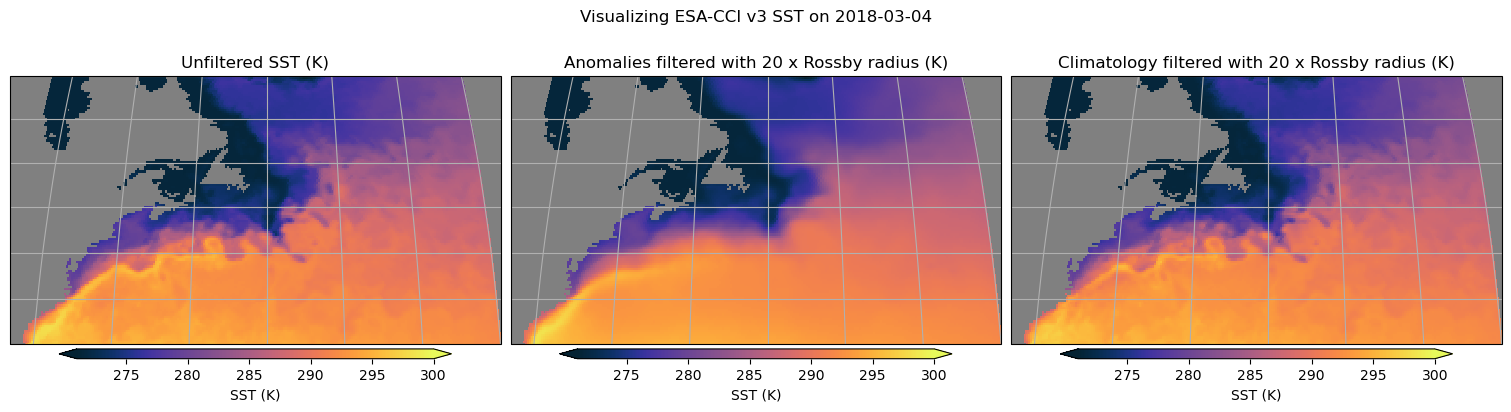

In [53]:
fig, axs = plt.subplots(
    1,
    3,
    constrained_layout=True,
    figsize=(15,4),
    # figsize=(15,10),
    subplot_kw=dict(
        projection=ccrs.Robinson(central_longitude=-50)
    )
)

ax = axs.flatten()

# use this for full resolution
sel = dict(
    lon=slice(-100,-10),
    lat=slice(25,65)
)
# use this low resolution: every 10th point in lat/lon - much faster!
# sel = dict(
#     lon=slice(-100,-10,10),
#     lat=slice(25,65,10)
# )

p = ds_2d_24h_0_0['avg_sst'].sel(realization=1,time='2018-03-04 12:00',lon=slice(-83,-20),lat=slice(30,60)).plot(
    transform=ccrs.PlateCarree(),
    ax=ax[0],
    cmap=cmo.thermal,
    vmin=271,
    vmax=300,
    cbar_kwargs=dict(
        orientation='horizontal',
        shrink=0.8,
        pad=0.0125,
        label='SST (K)',
        extend='both',
        aspect=40
    ),
    rasterized=True
)

q = ds_2d_24h_0_lr20['avg_sst'].sel(time='2018-03-04 12:00',lon=slice(-83,-20),lat=slice(30,60)).plot(
    transform=ccrs.PlateCarree(),
    ax=ax[1],
    cmap=cmo.thermal,
    vmin=271,
    vmax=300,
    cbar_kwargs=dict(
        orientation='horizontal',
        shrink=0.8,
        pad=0.0125,
        label='SST (K)',
        extend='both',
        aspect=40
    ),
    rasterized=True
)

r = ds_2d_24h_lr20_0['avg_sst'].sel(time='2018-03-04 12:00',lon=slice(-83,-20),lat=slice(30,60)).plot(
    transform=ccrs.PlateCarree(),
    ax=ax[2],
    cmap=cmo.thermal,
    vmin=271,
    vmax=300,
    cbar_kwargs=dict(
        orientation='horizontal',
        shrink=0.8,
        pad=0.0125,
        label='SST (K)',
        extend='both',
        aspect=40
    ),
    rasterized=True
)

[axi.set_extent([-83,-20,30,60],crs=ccrs.PlateCarree()) for axi in ax]
[axi.set_facecolor('grey') for axi in ax]

for axi in ax:
    ll = axi.gridlines()
    axi.set_title('')

ax[0].set_title('Unfiltered SST (K)')
ax[1].set_title('Anomalies filtered with 20 x Rossby radius (K)')
ax[2].set_title('Climatology filtered with 20 x Rossby radius (K)')
    
fig.suptitle('Visualizing ESA-CCI v3 SST on 2018-03-04')

# fig.savefig('ostia_obs_filtered_snapshot.pdf',dpi=300)

### Work with high-frequency data

In [54]:
# Get daily mean data from high-resolution run
ds_1279_2d_24h = ifs_to_latlon( # reshape to lat-lon grid
        cat_1279['hist.v20240901.atmos.gr025']['2D_24h'].to_dask()
)

In [57]:
# the point we are interesting in (Madrid as example)
lon_target = 8.5809
lat_target = 53.5396

tp_point = ds_1279_2d_24h['tprate'].sel(
    lon=lon_target,
    lat=lat_target,
    method='nearest')

In [58]:
tp_point

<xarray.DataArray 'tprate' (time: 16071)>
dask.array<getitem, shape=(16071,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 53.5
    lon      float64 8.5
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2023-12-31T12:00:00
Attributes: (12/30)
    paramId:                             172228
    dataType:                            fc
    numberOfPoints:                      1038240
    typeOfLevel:                         surface
    stepUnits:                           1
    stepType:                            avg
    ...                                  ...
    latitudeOfFirstGridPointInDegrees:   90.0
    longitudeOfFirstGridPointInDegrees:  0.0
    iDirectionIncrementInDegrees:        0.25
    jDirectionIncrementInDegrees:        0.25
    iScansNegatively:                    0
    jScansPositively:                    0

Load the data - this takes a while because (see just above) the data is stored as one chunk per timestep - so all the globe needs to be loaded even though only one gridpoint is requested

In [59]:
with ProgressBar():
    tp_point.load()

[########################################] | 100% Completed | 157.28 s


In [60]:
tp_point

<xarray.DataArray 'tprate' (time: 16071)>
array([4.14129318e-08, 2.33171704e-09, 4.88171281e-10, ...,
       7.17550392e-08, 2.06629238e-08, 6.93801212e-08])
Coordinates:
    lat      float64 53.5
    lon      float64 8.5
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2023-12-31T12:00:00
Attributes: (12/30)
    paramId:                             172228
    dataType:                            fc
    numberOfPoints:                      1038240
    typeOfLevel:                         surface
    stepUnits:                           1
    stepType:                            avg
    ...                                  ...
    latitudeOfFirstGridPointInDegrees:   90.0
    longitudeOfFirstGridPointInDegrees:  0.0
    iDirectionIncrementInDegrees:        0.25
    jDirectionIncrementInDegrees:        0.25
    iScansNegatively:                    0
    jScansPositively:                    0

In [61]:
# Precipitation is saved as m/s -> convert to mm/day
tp_point = tp_point*86400*1000
tp_point.attrs['units'] = 'mm/day'

In [62]:
# Quick stats using pandas:
tp_point.to_pandas().describe()

count    16071.000000
mean         2.497707
std          3.798624
min          0.000000
25%          0.072824
50%          0.796883
75%          3.482489
max         50.052633
dtype: float64

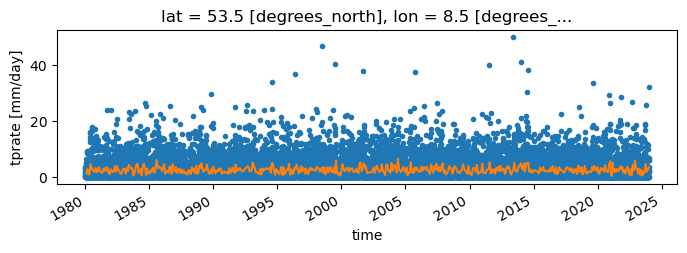

In [63]:
tp_point.plot.line(
    '.',
    figsize=(8,2)
)
tp_point.resample(time='1M').mean().plot()

Text(0.5, 1.0, 'Histogram of 6-hourly precipitation at 53.5 N, 8.6 E')

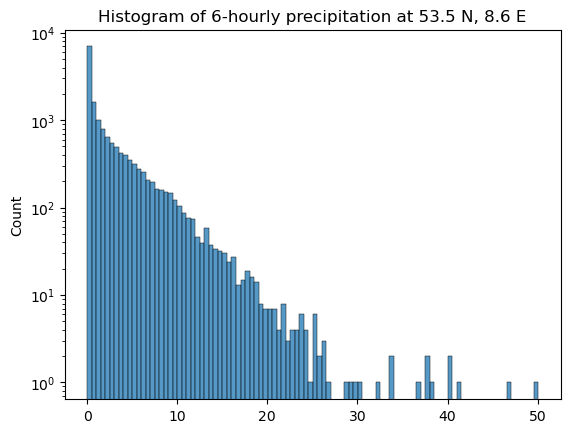

In [64]:
sns.histplot(
    tp_point,
    bins=100,
    log=True,
    # kde=True
)
plt.title('Histogram of 6-hourly precipitation at %.1f N, %.1f E' % (lat_target,lon_target))

In [65]:
# Get timestep with the highest precipitation:
tp_point_max_step = tp_point.to_pandas().sort_values().index[-1]#[[-1]].index.values

### Get one timestep over Europe, and plot precipitation together with z850 geopotential height contours

In [68]:
ds_1279_3d_24h = ifs_to_latlon( # reshape to lat-lon grid
        cat_1279['hist.v20240901.atmos.gr025']['3D_24h'].to_dask()
)

In [76]:
# Get pressure level daily mean data
ds_1279_3d_24h = ifs_to_latlon( # reshape to lat-lon grid
        cat_1279['hist.v20240901.atmos.gr025']['3D_24h'].to_dask()
)

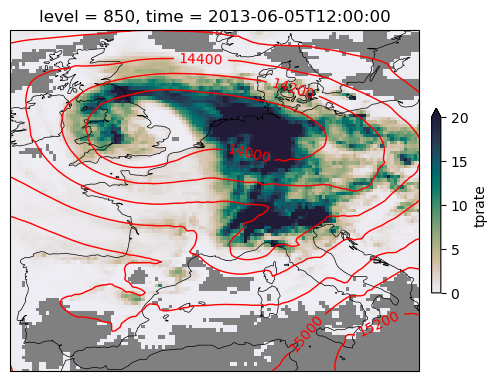

In [77]:
ff = (
    ds_1279_2d_24h['tprate'].sel(time=tp_point_max_step) 
    * 1000*86400
).where(
    lambda x:x>0 # mask points with no precipitation
).plot(
    subplot_kws=dict(
        projection=ccrs.PlateCarree()
    ),
    cbar_kwargs=dict(
        shrink=0.5,
        pad=0.025
    ),
    transform=ccrs.PlateCarree(),
    cmap=cmo.rain,
    vmin=0,
    vmax=20
)


p = (
    ds_1279_3d_24h['avg_z'].sel(time=tp_point_max_step).sel(lat=slice(30,80),level=850)
    # / 100
).plot.contour(
    ax=ff.axes,
    levels=20,
    colors='r',
    linewidths=1,
    transform=ccrs.PlateCarree(),
)

ff.axes.set_facecolor('grey')
ff.axes.set_extent([-10,20,35,60],crs=ccrs.PlateCarree())
ff.axes.clabel(p,fmt='%i')


ff.axes.coastlines(lw=0.5)